In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum
import pandas as pd
# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm
from os import makedirs, path as op
# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection, SHConfig, BBoxSplitter
from utils import (SentinelHubValidData, CountValid, NormalizedDifferenceIndex, ConcatenateData, ValidDataFractionPredicate)

In [2]:
CLIENT_ID = "f32c25a9-438e-44bd-ba96-1d95c33fe03a"
CLIENT_SECRET = "@&-d/1)m!SCR%6L?Ki7&v<cp?2G.1nI([(^mH|]u"
    
config = SHConfig()
config.instance_id = "8288f09c-5b87-49f8-81bc-76106c4581a6"
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == "" or config.sh_client_secret == "" or config.instance_id == "":
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimension of the area is 1320146 x 868415 m2
Dimension of the area is 132014 x 86841 pixels


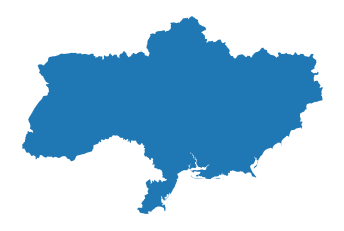

In [3]:
# Folder where data for running the notebook is located
DATA_FOLDER = os.path.join('.', 'example_data')

# Folder where data will be stored
EOPATCH_FOLDER = os.path.join('.', 'eopatches')
EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
RESULTS_FOLDER = os.path.join('.', 'results')
os.makedirs(EOPATCH_FOLDER, exist_ok=True)
os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)
os.makedirs(RESULTS_FOLDER, exist_ok=True)

#country = gpd.read_file(os.path.join(DATA_FOLDER, 'ukraine.geojson'))
countries = gpd.read_file('data.gpkg')
country = countries[countries.SOVEREIGNT.str.contains('Ukraine')]
# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N

if country.crs != country_crs:
    country = country.to_crs(crs=country_crs.pyproj_crs())

country_shape = country.geometry.tolist()[-1]
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))

bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

# Plot country
country.plot()
plt.axis('off');


/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


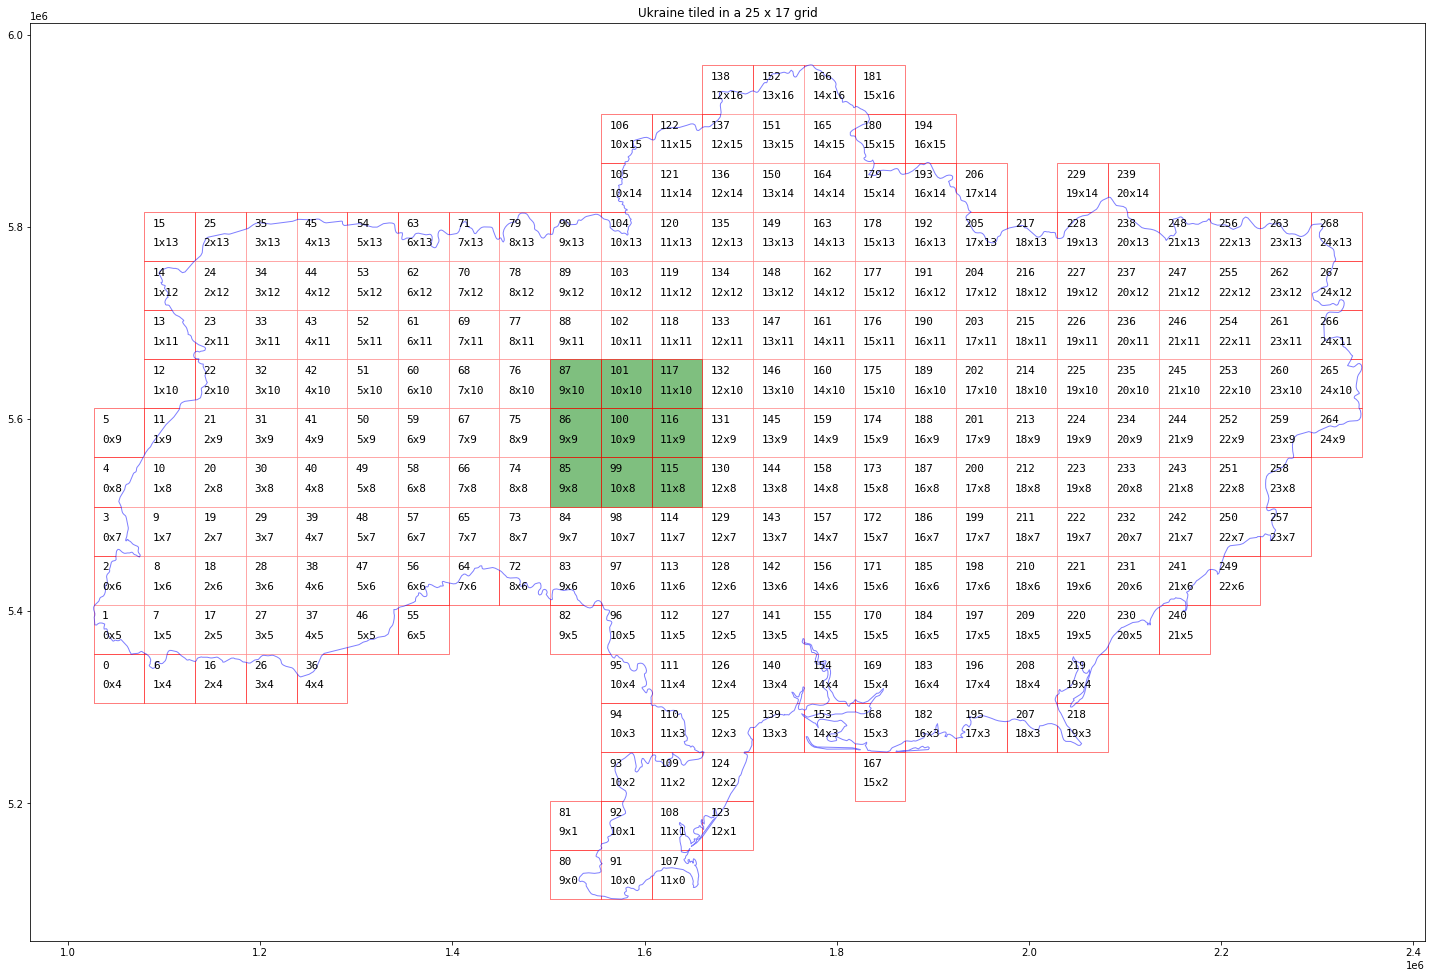

In [4]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()
# with open('./tile-def/slovenia_buffered_bbox_32633_17x25_293.pickle','rb') as fp:
#     bbox_splitter = pickle.load(fp)

# bbox_list = np.array(bbox_splitter.get_bbox_list())
# info_list = np.array(bbox_splitter.get_info_list())
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

ID = 100 
# Obtain surrounding patches
patchIDs = []
# Change the order of the patches (used for plotting later)
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Ukraine tiled in a 25 x 17 grid');
# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

if not os.path.isdir('./figs'):
    os.makedirs('./figs')
fig.savefig('./figs/aoi_to_tiles.png', bbox_inches='tight')
gdf[gdf.index.isin(patchIDs)].plot(ax=ax, facecolor='g', edgecolor='r', alpha=0.5)
    

shapefile_name = os.path.join(RESULTS_FOLDER, 'grid_ukraine_500x500.gpkg')
gdf.to_file(shapefile_name)

In [5]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['dataMask'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [50]:
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5,
    config=config
)

input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B02', 'B03', 'B04', 'B08', 'B11', 'B12'],
    bands_feature=(FeatureType.DATA, 'BANDS'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM')],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
    config=config
)
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate(), valid_data_feature='VALID_DATA')
# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [11]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [72]:
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
vector_feature = FeatureType.VECTOR_TIMELESS, 'LULC_REFERENCE'

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRaster(
    vector_feature,
    (FeatureType.MASK_TIMELESS, 'LULC'),
    values_column='lulcid',
    raster_shape=(FeatureType.MASK, 'VALID_DATA'),
    raster_dtype=np.uint8
)

In [77]:
time_interval = ('2021-01-01', '2021-02-20')
workflow = LinearWorkflow(
    input_task, 
    ndvi,
    ndwi,
    ndbi,
    add_valmask,
    vector_import_task,
    rasterization_task,
    save
    )
# result = workflow.execute({
#     input_task: {
#         'bbox': bbox_list[0],
#         'time_interval': time_interval
#     }
# })

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        spatial_sampling: {'seed': 42},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/9 [00:00<?, ?it/s]

Process ForkProcess-16:
Process ForkProcess-15:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkProcess-14:
Process ForkProcess-13:
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/vlas/anaconda3/envs/geo/lib/python3.8/multiprocessing/queues.py", line 239, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/vlas/anaconda3/envs/geo/lib/python3.8/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError: cannot pickle '_thread.RLock' object
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vlas/.local/lib/python3.8/site-packages/eolearn/core/eoexecution.py", line 150, in run
    self.execution_stats = list(tqdm(executor.map(self._execute_workflow, processing_args),
  File "/home/vlas/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 254, in __iter

TypeError: object of type 'NoneType' has no len()

In [75]:
EOPatch.load('./eopatches/eopatch_0')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(21, 319, 330, 6), dtype=float32)
    NDBI: numpy.ndarray(shape=(21, 319, 330, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(21, 319, 330, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(21, 319, 330, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(21, 319, 330, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(21, 319, 330, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(21, 319, 330, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    size_x: 330
    size_y: 319
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 2, 20, 23, 59, 59))
  }
  bbox: BBox(((1026458.0359745987, 5304779.020906753), (1079263.8891439147, 5355862.257929826)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2021, 1, 1, 9, 37

In [60]:
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [67]:
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), valid_data_predicate)
n_samples = 125000 # half of pixels
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC_ERODED',
    ref_labels=lulc_type_ids,
    sample_features=[(FeatureType.DATA, 'FEATURES'), (FeatureType.MASK_TIMELESS, 'LULC_ERODED')],
    )


/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
load = LoadTask(EOPATCH_FOLDER)
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
vector_feature = FeatureType.VECTOR_TIMELESS, 'LULC_REFERENCE'

vector_import_task = VectorImportTask(vector_feature, shapefile_name)

concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))

workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    spatial_sampling,
    save
)

In [69]:
%%time

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        spatial_sampling: {'seed': 42},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/9 [00:02<?, ?it/s]

RuntimeError: Execution failed EOPatches with IDs:
[0, 1, 2, 3, 4, 5, 6, 7, 8]
For more info check report at ./eoexecution-report-2021_06_22-15_20_54/report.html

In [64]:
sampled_eopatches = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER), lazy_loading=True)
sampled_eopatches

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
